In [3]:
# from google.colab import drive
from datetime import datetime
import numpy as np
import warnings

# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

import pandas as pd
import matplotlib.pyplot as plt
import math
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler


In [5]:
# Load data
path = 'dji_2009-2019.csv'
df = pd.read_csv(path, index_col=0)
close=df[['Close']]
close.head(10)

Close
Date                
1/2/09   9034.690430
1/5/09   8952.889648
1/6/09   9015.099609
1/7/09   8769.700195
1/8/09   8742.459961
1/9/09   8599.179688
1/12/09  8473.969727
1/13/09  8448.559570
1/14/09  8200.139648
1/15/09  8212.490234

**ARIMA MODEL**

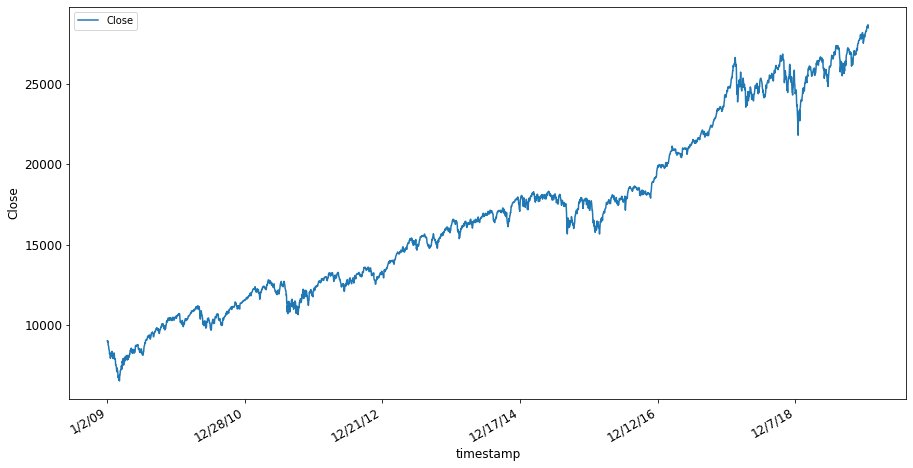

In [6]:
close.plot(y='Close', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

# Load 300 data
close[:300][['Close']].rename(columns={'Close':'train'}) \
    .plot(y=['train'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()

In [13]:
plt.plot(close[:100].diff())

** Create training and testing data sets **

Training data shape:  (1936, 1)
Test data shape:  (831, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

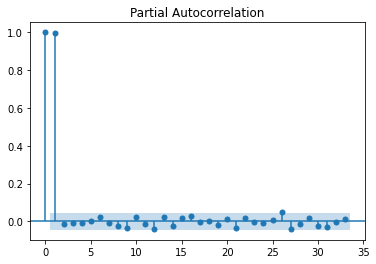

In [7]:
n = int(len(df) * 0.7)
m = int(len(df) * 0.7)

df_train = close.copy()[:n][['Close']]
df_test = close.copy()[m:][['Close']]

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)

plot_acf(df_train['Close'])
plot_pacf(df_train['Close'])
plt.show

** Data prepatation **

In [14]:
#SCALE TRAIN 
scaler=MinMaxScaler()
df_train['Close']=scaler.fit_transform(df_train)

close[:n][['Close']].rename(columns={'Close':'original trade close'}).plot.hist(bins=100, fontsize=12)
df_train.rename(columns={'Close':'scaled trade close'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [8]:
# SCALE TEST
df_test['Close'] = scaler.transform(df_test)
df_test.head()

Close
Date             
9/12/16  0.974276
9/13/16  0.952908
9/14/16  0.950262
9/15/16  0.964962
9/16/16  0.957627

** Implemnt ARIMA method **

In [9]:
# Specify the number of steps to forcast ahead
HORIZON=6
print('Forescating horizon:', HORIZON, 'days')

Forescating horizon: 6 days


In [10]:
df_test_shifted = df_test.copy()

for t in range(1, HORIZON):
    df_test_shifted['Close+'+str(t)] = df_test_shifted['Close'].shift(-t)

df_test_shifted=df_test_shifted.dropna(how='any')
df_test_shifted.head(5)

Close   Close+1   Close+2   Close+3   Close+4   Close+5
Date                                                               
9/12/16  0.974276  0.952908  0.950262  0.964962  0.957627  0.957326
9/13/16  0.952908  0.950262  0.964962  0.957627  0.957326  0.958136
9/14/16  0.950262  0.964962  0.957627  0.957326  0.958136  0.971681
9/15/16  0.964962  0.957627  0.957326  0.958136  0.971681  0.979850
9/16/16  0.957627  0.957326  0.958136  0.971681  0.979850  0.969013

In [15]:
order=(1,1,1)
model=ARIMA(df_train,order=order)
results=model.fit()

print(results.summary())

/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1936
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6068.774
Date:                Sun, 27 Dec 2020   AIC                         -12131.548
Time:                        09:16:52   BIC                         -12114.844
Sample:                             0   HQIC                        -12125.404
                               - 1936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5159      0.254     -2.033      0.042      -1.013      -0.018
ma.L1          0.4718      0.262      1.797      0.072      -0.043       0.986
sigma2         0.0001    2.5e-06     44.166      0.0

In [12]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts_data):
    
    # Q1 **********************Hoàn thành đoạn code sau đây*************
    # Rolling statistics
    roll_mean = ts_data.rolling(30, center=True, closed='both').mean()
    roll_std = ts_data.rolling(5, center=True, closed='both').std()
    #****************************************************************
    
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

In [13]:
df.index = pd.to_datetime(df.index, format="%m/%d/%y")
df_final = pd.Series(df['Close'])
type(df_final)

pandas.core.series.Series

In [14]:
check_stationarity(df_final)

Dickey-Fuller test results

Test Statistic       0.220418
p-value              0.973384
# of lags           26.000000
# of obs          2740.000000
dtype: float64
Critical value at 1%: -3.43274
Critical value at 5%: -2.86260
Critical value at 10%: -2.56733


-> Dữ liệu chưa stationary

In [15]:
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic   -1.127456e+01
p-value           1.507773e-20
# of lags         2.500000e+01
# of obs          2.740000e+03
dtype: float64
Critical value at 1%: -3.43274
Critical value at 5%: -2.86260
Critical value at 10%: -2.56733


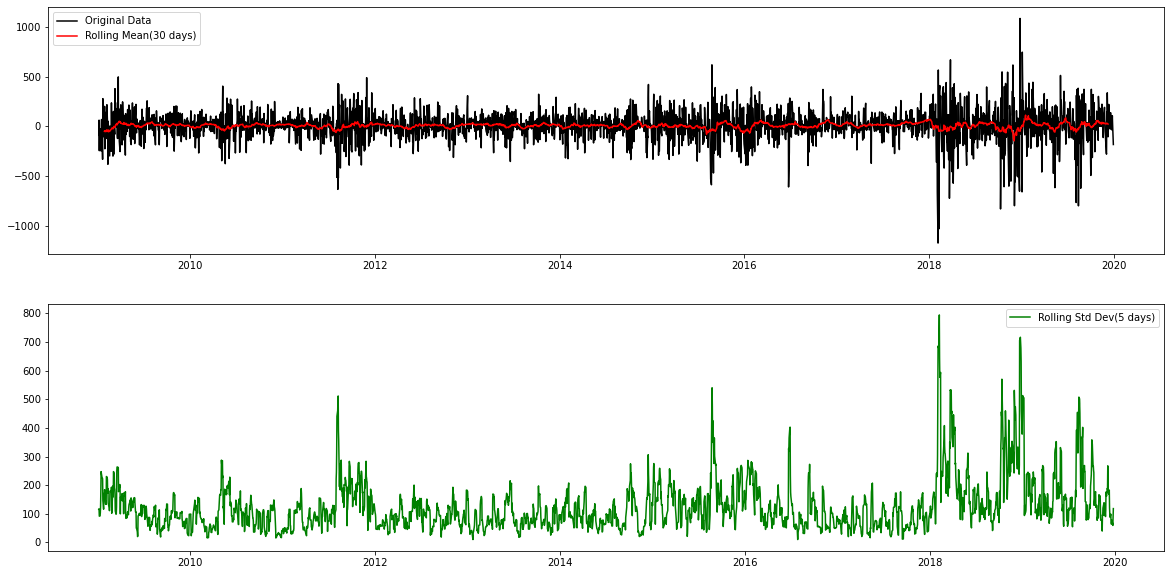

In [16]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

-> Dữ liệu đã stationary

** Evaluate the model **

In [17]:
training_window= 30 # dedicate 30 days for training

train_ts=df_train['Close']
test_ts=df_test_shifted

history=[x for x in train_ts]
history=history[(-training_window):]

predictions=list()

for i in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=HORIZON)
    predictions.append(output)
    obs=list(test_ts.iloc[i])
    history.append(obs[0])
    history.pop(0)

/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/p

/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/

/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/

/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/HPhuc/miniconda3/lib/python3.8/site-packages/statsmodels/

In [18]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.031


In [19]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = df_test.index[0:len(df_test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h    prediction       actual
0   9/12/16  t+1  18085.450160  18325.07031
1   9/13/16  t+1  18233.487478  18066.75000
2   9/14/16  t+1  18285.197045  18034.76953
3   9/15/16  t+1  18028.113227  18212.48047
4   9/16/16  t+1  18132.328241  18123.80078

<ipython-input-21-3bfb2b347fe3>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
No handles with labels found to put in legend.


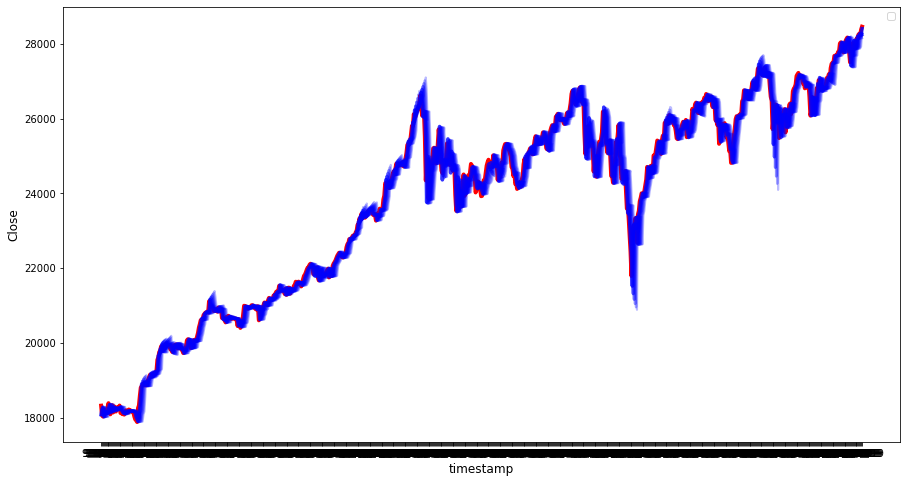

In [21]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.show()